In [3]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from matplotlib.path import Path
import json
import zipfile
import io
import os
import utm

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool, Legend, ColumnDataSource, Title
from bokeh.tile_providers import get_provider, CARTODBPOSITRON
from bokeh.models import GeoJSONDataSource

output_notebook()

Loading BokehJS ...

In [4]:
r = requests.get("https://datos.madrid.es/egob/catalogo/208627-32-transporte-ptomedida-historico.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
if not os.path.exists("data/2016"):
    os.mkdir("data/2016")
z.extractall("data/2016/")

In [5]:
jan_2016 = pd.read_csv("data/2016/01-2016.csv", sep=";")
jan_2016.head()

,idelem,fecha,identif,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
0,3581,2016-01-01 09:15:00,61079,PUNTOS MEDIDA URBANOS,40,0,0,0,N,1
1,3982,2016-01-01 00:00:00,06042,PUNTOS MEDIDA URBANOS,52,0,2,0,N,13
2,4291,2016-01-01 09:15:00,16013,PUNTOS MEDIDA URBANOS,43,4,12,0,N,7
3,4200,2016-01-01 09:15:00,14002,PUNTOS MEDIDA URBANOS,52,0,4,0,N,14
4,5928,2016-01-01 09:15:00,44030,PUNTOS MEDIDA URBANOS,124,0,6,0,N,13


In [6]:
jan_2016["idelem"].unique().shape

(3797,)

In [7]:
r = requests.get("https://datos.madrid.es/egob/catalogo/202468-2-intensidad-trafico.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
if not os.path.exists("data/traffic_points"):
    os.mkdir("data/traffic_points")
z.extractall("data/traffic_points/")

In [8]:
def from_latlon(lat, lon):
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + 
        lat * (np.pi/180.0)/2.0)) * scale

    return x, y

def get_lat_lon_utm(row):

    # 30 and 'T' is the zone of Madrid
    lat, lon = utm.to_latlon(row["st_x"], row["st_y"], 30, "T")
    
    x, y = from_latlon(lat, lon)

    return pd.Series([lat, lon, x, y])

In [9]:
traffic_points = pd.read_csv("shared_data/traffic_points/pmed_trafico_03052016.csv", sep=";")

traffic_points[["latitude", "longitude", "utm_x", "utm_y"]] = traffic_points.apply(get_lat_lon_utm, axis=1)

traffic_points.head()

,idelem,tipo_elem,cod_cent,nombre,st_x,st_y,latitude,longitude,utm_x,utm_y
0,1044,494,03FT08PM01,03FT08PM01,438963.314635,4.474734e+06,40.421001,-3.719488,-414051.481782,4.927311e+06
1,3600,494,PM30901,PM30901,443729.047369,4.473268e+06,40.408129,-3.663184,-407783.811885,4.925429e+06
2,3705,494,PM41451,PM41451,439858.261097,4.471574e+06,40.392598,-3.708640,-412843.963659,4.923159e+06
3,6823,494,PM41453,PM41453,439188.095183,4.470895e+06,40.386431,-3.716471,-413715.710072,4.922257e+06
4,7033,495,01015,Pº Castellana S-N - Pl. Colon-Hermosilla,441569.555897,4.475502e+06,40.428107,-3.688839,-410639.639249,4.928350e+06


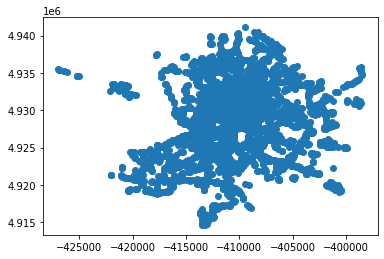

In [10]:
plt.scatter(traffic_points["utm_x"], traffic_points["utm_y"])

In [11]:
with open("shared_data/districts/districts.geojson", "r") as geojson:
    geodata = json.load(geojson)

# for i in range(len(geodata['features'])):
#     geodata['features'][i]['properties']['Color'] = ['blue', 'red'][i%2]

In [12]:
g_data = pd.DataFrame(geodata["features"][0]["geometry"]["coordinates"][0], columns=["st_x", "st_y"])
g_data[["latitude", "longitude", "utm_x", "utm_y"]] = g_data.apply(get_lat_lon_utm, axis=1)
g_data.head()

,st_x,st_y,latitude,longitude,utm_x,utm_y
0,441184.784,4473200.78,40.407345,-3.693162,-411120.867401,4.925314e+06
1,441181.244,4473184.23,40.407196,-3.693202,-411125.341089,4.925293e+06
2,441178.884,4473160.91,40.406986,-3.693227,-411128.197118,4.925262e+06
3,441140.854,4473176.92,40.407127,-3.693677,-411178.251532,4.925282e+06
4,441126.355,4473191.33,40.407256,-3.693849,-411197.420454,4.925301e+06


In [13]:
path = Path(g_data[["utm_x", "utm_y"]].values)
points = traffic_points[["utm_x", "utm_y"]].values

points_in_path_mask = path.contains_points(points)

traffic_points["color"] = "red"

traffic_points.loc[points_in_path_mask, "color"] = "blue"
traffic_points.head()

,idelem,tipo_elem,cod_cent,nombre,st_x,st_y,latitude,longitude,utm_x,utm_y,color
0,1044,494,03FT08PM01,03FT08PM01,438963.314635,4.474734e+06,40.421001,-3.719488,-414051.481782,4.927311e+06,red
1,3600,494,PM30901,PM30901,443729.047369,4.473268e+06,40.408129,-3.663184,-407783.811885,4.925429e+06,red
2,3705,494,PM41451,PM41451,439858.261097,4.471574e+06,40.392598,-3.708640,-412843.963659,4.923159e+06,red
3,6823,494,PM41453,PM41453,439188.095183,4.470895e+06,40.386431,-3.716471,-413715.710072,4.922257e+06,red
4,7033,495,01015,Pº Castellana S-N - Pl. Colon-Hermosilla,441569.555897,4.475502e+06,40.428107,-3.688839,-410639.639249,4.928350e+06,red


In [14]:
p = figure(title="My first interactive plot!", x_axis_type="mercator", y_axis_type="mercator")

source = ColumnDataSource(traffic_points)
p.circle(x="utm_x", y="utm_y",  size=3, color="color", source=source)

source = ColumnDataSource(g_data)
p.line(x="utm_x", y="utm_y",  color="green", line_width=6, alpha=0.7, source=source)

cartodb = get_provider(CARTODBPOSITRON)
p.add_tile(cartodb)

show(p)